In [1]:
!pip install opencv-python pandas scikit-learn torch torchvision pillow matplotlib tqdm

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Configurazione
dataset_path = 'flowers'
output_train = 'train.csv'
output_val = 'val.csv'

# 1. Raccoglie tutti i file
data = []
for label in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, label)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                data.append({
                    'path': os.path.join(class_dir, filename),
                    'label': label
                })

df = pd.DataFrame(data)

# 2. Bilanciamento (Undersampling)
# Trova la classe con meno immagini
min_samples = df['label'].value_counts().min()

# CORREZIONE WARNING: Usiamo direttamente .sample() sul groupby
df_balanced = df.groupby('label').sample(n=min_samples, random_state=42).reset_index(drop=True)

# 3. Split 80/20 Stratificato
train_df, val_df = train_test_split(
    df_balanced, 
    test_size=0.20, 
    stratify=df_balanced['label'], 
    random_state=42
)

# 4. Salva i file CSV
train_df.to_csv(output_train, index=False)
val_df.to_csv(output_val, index=False)

print(f"Dataset creato senza errori.")
print(f"Train: {len(train_df)} immagini -> salvato in '{output_train}'")
print(f"Val:   {len(val_df)} immagini -> salvato in '{output_val}'")

Numero minimo di immagini per classe: 489
Dataset creato senza errori.
Train: 7432 immagini -> salvato in 'train.csv'
Val:   1859 immagini -> salvato in 'val.csv'


In [5]:
import cv2
import numpy as np
import pandas as pd # Usiamo pandas che è più comodo per leggere i CSV

# 1. Creiamo prima la mappa per convertire i nomi (rose) in numeri (0)
# Leggiamo il train solo per estrarre la lista delle classi uniche
df_temp = pd.read_csv("train.csv")
classes = sorted(df_temp['label'].unique())
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
print(f"Mappa delle classi generata: {class_to_idx}")

def carica_dataset_da_csv(csv_path):
    # Legge il CSV saltando automaticamente l'header
    df = pd.read_csv(csv_path)
    
    images = []
    labels = []
    
    print(f"Inizio caricamento {len(df)} immagini da {csv_path}...")
    
    # Itera su ogni riga del CSV
    for index, row in df.iterrows():
        path = row['path']
        label_name = row['label'] # Qui è una stringa (es: 'rose')
        
        # Carica immagine con OpenCV
        img = cv2.imread(path)
        
        if img is None:
            print(f"Errore: Impossibile leggere {path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB
        img = cv2.resize(img, (128, 128)) # Ridimensiona
        img = img / 255.0 # Normalizza (0-1)
        
        images.append(img)
        # Convertiamo la stringa 'rose' nel numero corrispondente
        labels.append(class_to_idx[label_name])
        
    return np.array(images), np.array(labels)

# --- ESECUZIONE ---

# Carica Train
X_train, y_train = carica_dataset_da_csv("train.csv")

# Carica Val
X_val, y_val = carica_dataset_da_csv("val.csv")


print(f"X_train shape: {X_train.shape}") # (N_samples, 128, 128, 3)
print(f"y_train shape: {y_train.shape}")
import matplotlib.pyplot as plt
import numpy as np


Mappa delle classi generata: {'astilbe': 0, 'bellflower': 1, 'black_eyed_susan': 2, 'calendula': 3, 'california_poppy': 4, 'carnation': 5, 'common_daisy': 6, 'coreopsis': 7, 'daffodil': 8, 'dandelion': 9, 'iris': 10, 'lavender': 11, 'lotus': 12, 'magnolia': 13, 'orchid': 14, 'rose': 15, 'sunflower': 16, 'tulip': 17, 'water_lily': 18}
Inizio caricamento 7432 immagini da train.csv...
Inizio caricamento 1859 immagini da val.csv...
X_train shape: (7432, 128, 128, 3)
y_train shape: (7432,)


=== STATISTICHE DATASET TRAIN ===
Numero totale immagini: 7432
Dimensione immagine: 128x128 con 3 canali
Valore minimo pixel: 0.00 (Dovrebbe essere 0.0)
Valore massimo pixel: 1.00 (Dovrebbe essere 1.0)

Train
Classe 0 (astilbe): 392 immagini
Classe 1 (bellflower): 391 immagini
Classe 2 (black_eyed_susan): 391 immagini
Classe 3 (calendula): 391 immagini
Classe 4 (california_poppy): 391 immagini
Classe 5 (carnation): 392 immagini
Classe 6 (common_daisy): 391 immagini
Classe 7 (coreopsis): 391 immagini
Classe 8 (daffodil): 391 immagini
Classe 9 (dandelion): 391 immagini
Classe 10 (iris): 391 immagini
Classe 11 (lavender): 392 immagini
Classe 12 (lotus): 391 immagini
Classe 13 (magnolia): 391 immagini
Classe 14 (orchid): 391 immagini
Classe 15 (rose): 391 immagini
Classe 16 (sunflower): 391 immagini
Classe 17 (tulip): 391 immagini
Classe 18 (water_lily): 391 immagini

Val
Classe 0 (astilbe): 97 immagini
Classe 1 (bellflower): 98 immagini
Classe 2 (black_eyed_susan): 98 immagini
Classe 3 (c

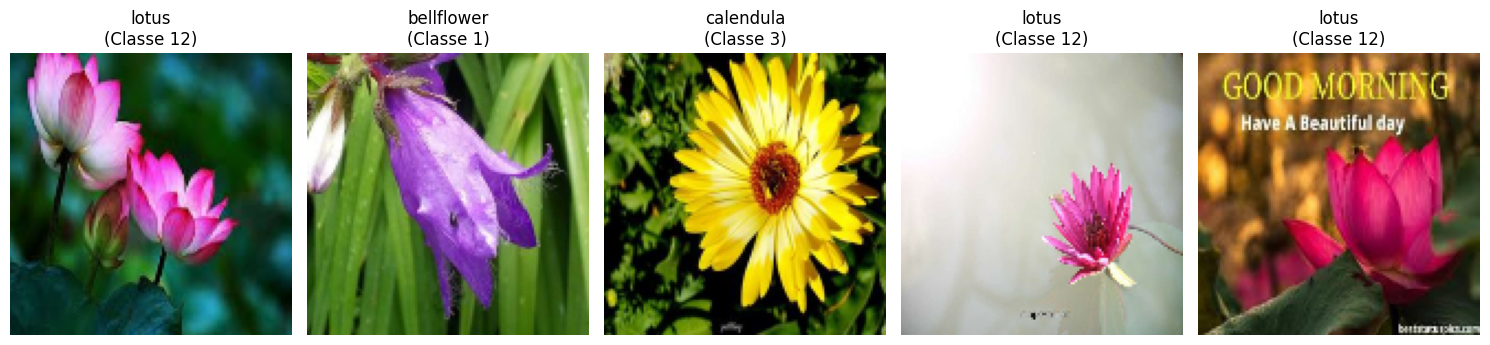

In [6]:
# --- 1. INFO NUMERICHE ---
print("=== STATISTICHE DATASET TRAIN ===")
print(f"Numero totale immagini: {X_train.shape[0]}")
print(f"Dimensione immagine: {X_train.shape[1]}x{X_train.shape[2]} con {X_train.shape[3]} canali")
print(f"Valore minimo pixel: {X_train.min():.2f} (Dovrebbe essere 0.0)")
print(f"Valore massimo pixel: {X_train.max():.2f} (Dovrebbe essere 1.0)")

print("\nTrain")
# Conta quante immagini ci sono per ogni classe (0, 1, 2...)
unique, counts = np.unique(y_train, return_counts=True)
for label_idx, count in zip(unique, counts):
    # Recupera il nome originale dalla mappa
    # (Cerchiamo la chiave che ha come valore 'label_idx')
    nome_classe = [k for k, v in class_to_idx.items() if v == label_idx][0]
    print(f"Classe {label_idx} ({nome_classe}): {count} immagini")

print("\nVal")
# Conta quante immagini ci sono per ogni classe (0, 1, 2...)
unique, counts = np.unique(y_val, return_counts=True)
for label_idx, count in zip(unique, counts):
    # Recupera il nome originale dalla mappa
    # (Cerchiamo la chiave che ha come valore 'label_idx')
    nome_classe = [k for k, v in class_to_idx.items() if v == label_idx][0]
    print(f"Classe {label_idx} ({nome_classe}): {count} immagini")

# --- 2. VISUALIZZAZIONE ESEMPI ---
print("\nESEMPI VISIVI")
fig, axes = plt.subplots(1, 5, figsize=(15, 4)) # Crea una riga con 5 grafici

# Ricrea mappa inversa per avere i nomi (0 -> 'rose')
idx_to_class = {v: k for k, v in class_to_idx.items()}

for i in range(5):
    # Prendi un indice a caso
    idx_random = np.random.randint(0, len(X_train))
    
    img = X_train[idx_random]
    label = y_train[idx_random]
    nome_label = idx_to_class[label]
    
    # Mostra immagine
    axes[i].imshow(img)
    axes[i].set_title(f"{nome_label}\n(Classe {label})")
    axes[i].axis('off') # Nasconde gli assi x/y

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. Configurazione Device (MPS per Mac)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Usando accelerazione Apple MPS (Metal)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Usando accelerazione CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("⚠️ MPS e CUDA non trovati, uso CPU")

# 2. Conversione da Numpy a Tensor
# X_train è (N, 128, 128, 3) -> PyTorch vuole (N, 3, 128, 128)
# Usiamo .permute(0, 3, 1, 2) per spostare i canali
X_train_tensor = torch.Tensor(X_train).permute(0, 3, 1, 2).float()
y_train_tensor = torch.LongTensor(y_train) # Le label devono essere Long (interi)

X_val_tensor = torch.Tensor(X_val).permute(0, 3, 1, 2).float()
y_val_tensor = torch.LongTensor(y_val)

# 3. Creazione dei DataLoader (per gestire i batch)
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Dati convertiti in Tensori PyTorch e caricati nei Loader.")


⚠️ MPS non trovato, uso CPU
Dati convertiti in Tensori PyTorch e caricati nei Loader.


In [8]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn

class OptimizedCNN(nn.Module):
    def __init__(self, num_classes=19):
        super(OptimizedCNN, self).__init__()
        
        # --- BLOCCO ESTRAZIONE FEATURES ---
        # Aumentiamo la profondità (4 blocchi) ma usiamo GAP alla fine
        
        # Blocco 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # Normalizza: aiuta la rete a imparare meglio
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 128 -> 64
        )
        
        # Blocco 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 64 -> 32
        )
        
        # Blocco 3
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 32 -> 16
        )
        
        # Blocco 4 (Nuovo: per capire forme più complesse)
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 16 -> 8
        )
        
        # --- CLASSIFICATORE LEGGERO ---
        # Invece di Flatten(), usiamo AdaptiveAvgPool2d((1,1))
        # Questo riduce tutto a (Batch, 256, 1, 1) -> Vettore di 256
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),       # Ora appiattisce solo 256 numeri!
            nn.Dropout(0.5),    # Spegne il 50% dei neuroni per evitare memorizzazione
            nn.Linear(256, num_classes) # Solo un layer finale pulito
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

# Verifica parametri
model = OptimizedCNN(num_classes=19)
params = sum(p.numel() for p in model.parameters())
print(f"Modello Ottimizzato creato.")
print(f"Parametri totali: {params:,}") 
# Noterai che i parametri sono pochissimi rispetto a prima, ma la rete è più profonda!

Modello Ottimizzato creato.
Parametri totali: 394,259


In [52]:
import torch.optim as optim
from tqdm import tqdm

# Configurazione
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = OptimizedCNN(num_classes=19).to(device)

# Aumentiamo un po' il Learning Rate iniziale perché c'è BatchNorm
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

epochs = 30

print("Inizio training OptimizedCNN...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
    
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        loop.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    train_acc = 100 * correct_train / total_train
    val_acc = 100 * correct_val / total_val
    
    loop.write(f" -> Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

Inizio training OptimizedCNN...


Epoch 1/30: 100%|██████████| 233/233 [00:11<00:00, 20.38it/s, loss=2.09]


 -> Train Acc: 30.50% | Val Acc: 40.24%


Epoch 2/30: 100%|██████████| 233/233 [00:10<00:00, 21.19it/s, loss=2.57]


 -> Train Acc: 41.75% | Val Acc: 47.44%


Epoch 3/30: 100%|██████████| 233/233 [00:11<00:00, 21.10it/s, loss=2.62]


 -> Train Acc: 47.17% | Val Acc: 52.07%


Epoch 4/30: 100%|██████████| 233/233 [00:11<00:00, 21.15it/s, loss=1.13]


 -> Train Acc: 50.11% | Val Acc: 53.85%


Epoch 5/30: 100%|██████████| 233/233 [00:11<00:00, 21.08it/s, loss=3.08] 


 -> Train Acc: 53.65% | Val Acc: 54.33%


Epoch 6/30: 100%|██████████| 233/233 [00:11<00:00, 21.08it/s, loss=1.24] 


 -> Train Acc: 55.42% | Val Acc: 54.71%


Epoch 7/30: 100%|██████████| 233/233 [00:11<00:00, 21.00it/s, loss=1.87] 


 -> Train Acc: 57.63% | Val Acc: 52.39%


Epoch 8/30: 100%|██████████| 233/233 [00:11<00:00, 21.10it/s, loss=1.72] 


 -> Train Acc: 59.14% | Val Acc: 53.74%


Epoch 9/30: 100%|██████████| 233/233 [00:11<00:00, 21.10it/s, loss=2.46] 


 -> Train Acc: 60.01% | Val Acc: 61.16%


Epoch 10/30: 100%|██████████| 233/233 [00:11<00:00, 21.09it/s, loss=1.11] 


 -> Train Acc: 60.90% | Val Acc: 59.87%


Epoch 11/30: 100%|██████████| 233/233 [00:11<00:00, 20.87it/s, loss=1.6]  


 -> Train Acc: 62.89% | Val Acc: 58.69%


Epoch 12/30: 100%|██████████| 233/233 [00:11<00:00, 20.07it/s, loss=0.892]


 -> Train Acc: 64.06% | Val Acc: 62.99%


Epoch 13/30: 100%|██████████| 233/233 [00:10<00:00, 21.93it/s, loss=1.29] 


 -> Train Acc: 65.11% | Val Acc: 65.63%


Epoch 14/30: 100%|██████████| 233/233 [00:10<00:00, 21.76it/s, loss=1.56] 


 -> Train Acc: 64.71% | Val Acc: 65.57%


Epoch 15/30: 100%|██████████| 233/233 [00:10<00:00, 21.96it/s, loss=1.14] 


 -> Train Acc: 66.59% | Val Acc: 64.93%


Epoch 16/30: 100%|██████████| 233/233 [00:10<00:00, 21.64it/s, loss=0.362]


 -> Train Acc: 67.40% | Val Acc: 67.08%


Epoch 17/30: 100%|██████████| 233/233 [00:11<00:00, 20.09it/s, loss=1.47] 


 -> Train Acc: 68.37% | Val Acc: 65.20%


Epoch 18/30: 100%|██████████| 233/233 [00:11<00:00, 20.66it/s, loss=1.04] 


 -> Train Acc: 69.59% | Val Acc: 68.75%


Epoch 19/30: 100%|██████████| 233/233 [00:11<00:00, 21.16it/s, loss=0.492]


 -> Train Acc: 70.17% | Val Acc: 66.59%


Epoch 20/30:  55%|█████▍    | 128/233 [00:06<00:04, 21.14it/s, loss=1.07] 


KeyboardInterrupt: 